# ERP 주문서 데이터 분석

이 노트북에서는 `erp_order_form.xlsx` 파일을 분석해보겠습니다.

## 1. 라이브러리 로드 및 데이터 읽기

In [36]:
# 필요한 라이브러리 import
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns  # 일단 주석처리
from datetime import datetime

# 한글 폰트 설정 (그래프에서 한글이 깨지지 않도록)
plt.rcParams['font.family'] = 'AppleGothic'  # Mac용
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


In [ ]:
# 오전/오후 데이터 통합 읽기
try:
    # 오전, 오후 시트 모두 읽어서 통합
    df_morning = pd.read_excel('erp_order_form.xlsx', sheet_name='오전')
    df_afternoon = pd.read_excel('erp_order_form.xlsx', sheet_name='오후')
    
    # 두 시트 합치기
    df = pd.concat([df_morning, df_afternoon], ignore_index=True)
    
    print("✅ 엑셀 파일 읽기 성공!")
    print(f"📊 오전: {len(df_morning)}건 + 오후: {len(df_afternoon)}건 = 총 {len(df)}건")
    print(f"📊 데이터 크기: {df.shape[0]}행 × {df.shape[1]}열")
    print(f"👥 총 고객 수: {df['주문자명'].nunique():,}명")
    print("\n컬럼 목록:")
    print(df.columns.tolist())
except Exception as e:
    print(f"❌ 파일 읽기 실패: {e}")
    print("pandas와 openpyxl이 설치되어 있는지 확인하세요!")
    print("설치 명령: pip install pandas openpyxl")

/## 🔥 프로페셔널 리셀러 판단 시스템

실무에서 바로 사용 가능한 리셀러 판단 분석:
- **5대 핵심 지표**: 구매량, 정기성, 주소, 다양성, 규모
- **자동 판정**: 확실한 리셀러 / 가능성 높음 / 잠재 / 일반
- **프리미엄 엑셀 리포트**: 색상, 차트, 조건부 서식 포함

In [38]:
# 리셀러 판단 핵심 함수 정의
import re

def detect_business_address(address):
    """사업장 주소 감지"""
    if pd.isna(address):
        return 0
    
    address_str = str(address)
    business_keywords = [
        '사무실', '오피스', '빌딩', '타워', '센터', '상가', '층',
        '호실', '번지', '공장', '창고', '물류', '유통', '산업',
        '비즈니스', '스퀘어', '프라자', '몰', '마켓', '상점'
    ]
    
    for keyword in business_keywords:
        if keyword in address_str:
            return 1  # 사업장
    return 0  # 일반 주소

def analyze_reseller_patterns(df):
    """리셀러 패턴 종합 분석"""
    
    # 날짜 변환
    df['주문일자'] = pd.to_datetime(df['주문일자'], errors='coerce')
    
    # 고객별 집계
    analysis = df.groupby('주문자명').agg({
        '주문수량': ['sum', 'mean', 'std'],
        '총매출액': 'sum',
        '주문번호(쇼핑몰)': 'count',
        '상품명': ['nunique', lambda x: ', '.join(x.value_counts().head(3).index)],
        '주소': lambda x: x.mode()[0] if len(x) > 0 else '',
        '주문일자': ['min', 'max', lambda x: (x.max() - x.min()).days if len(x) > 1 else 0]
    }).round(2)
    
    # 컬럼명 정리
    analysis.columns = [
        '총구매수량', '평균구매수량', '수량편차',
        '총매출액',
        '주문횟수',
        '구매제품종류', '주력상품TOP3',
        '대표주소',
        '첫구매일', '최근구매일', '활동기간(일)'
    ]
    
    # 사업장 주소 여부
    analysis['사업장주소'] = analysis['대표주소'].apply(detect_business_address)
    
    # 구매 주기
    analysis['평균구매주기'] = (analysis['활동기간(일)'] / analysis['주문횟수']).replace([float('inf'), -float('inf')], 0).round(1)
    
    return analysis

In [39]:
# 리셀러 점수 계산 시스템
def calculate_professional_reseller_score(stats):
    """전문 리셀러 점수 계산"""
    
    scores = pd.DataFrame(index=stats.index)
    
    # 1. 대량 구매 지표 (30점)
    scores['대량구매'] = stats['평균구매수량'].apply(
        lambda x: 30 if x >= 5 else 20 if x >= 3 else 10 if x >= 2 else 0
    )
    
    # 2. 정기성 지표 (25점)
    scores['정기구매'] = stats.apply(
        lambda x: 25 if (x['주문횟수'] >= 5 and x['활동기간(일)'] >= 30) else
                  15 if (x['주문횟수'] >= 3 and x['활동기간(일)'] >= 14) else
                  5 if x['주문횟수'] >= 2 else 0,
        axis=1
    )
    
    # 3. 사업장 주소 (20점)
    scores['사업장'] = stats['사업장주소'] * 20
    
    # 4. 제품 다양성 (15점)
    scores['다양성'] = stats['구매제품종류'].apply(
        lambda x: 15 if x >= 5 else 10 if x >= 3 else 5 if x >= 2 else 0
    )
    
    # 5. 구매 규모 (10점)
    scores['구매규모'] = stats['총매출액'].apply(
        lambda x: 10 if x >= 200000 else 7 if x >= 100000 else 3 if x >= 50000 else 0
    )
    
    # 총점
    scores['리셀러점수'] = scores.sum(axis=1)
    
    # 판정
    scores['판정'] = scores['리셀러점수'].apply(
        lambda x: '🔴 확실한 리셀러' if x >= 70 else
                  '🟠 리셀러 가능성 높음' if x >= 50 else
                  '🟡 잠재 리셀러' if x >= 30 else
                  '🟢 일반 고객'
    )
    
    # 등급 (엑셀용)
    scores['등급'] = scores['리셀러점수'].apply(
        lambda x: 'A' if x >= 70 else 'B' if x >= 50 else 'C' if x >= 30 else 'D'
    )
    
    # 원본 데이터와 합치기
    final = pd.concat([stats, scores], axis=1)
    
    return final

# 분석 실행
print("🔍 리셀러 패턴 분석 중...")
customer_analysis = analyze_reseller_patterns(df)
final_results = calculate_professional_reseller_score(customer_analysis)

print(f"✅ 분석 완료: {len(final_results)}명 고객")

# 통계
total = len(final_results)
a_grade = len(final_results[final_results['등급'] == 'A'])
b_grade = len(final_results[final_results['등급'] == 'B'])
c_grade = len(final_results[final_results['등급'] == 'C'])

print(f"\n📊 리셀러 분포:")
print(f"🔴 A등급 (확실한 리셀러): {a_grade}명 ({a_grade/total*100:.1f}%)")
print(f"🟠 B등급 (가능성 높음): {b_grade}명 ({b_grade/total*100:.1f}%)")
print(f"🟡 C등급 (잠재 리셀러): {c_grade}명 ({c_grade/total*100:.1f}%)")

🔍 리셀러 패턴 분석 중...
✅ 분석 완료: 845명 고객

📊 리셀러 분포:
🔴 A등급 (확실한 리셀러): 0명 (0.0%)
🟠 B등급 (가능성 높음): 2명 (0.2%)
🟡 C등급 (잠재 리셀러): 23명 (2.7%)


In [40]:
# 상위 리셀러 상세 보고
print("\n🔥 상위 리셀러 후보 (즉시 연락 필요)")
print("=" * 70)

top_resellers = final_results.nlargest(10, '리셀러점수')

for idx, row in top_resellers.iterrows():
    if row['리셀러점수'] >= 30:  # 잠재 리셀러 이상만
        print(f"\n👤 {idx}")
        print(f"   📊 등급: {row['판정']}")
        print(f"   🎯 점수: {row['리셀러점수']:.0f}점")
        print(f"   📦 주문: {row['주문횟수']}회, 평균 {row['평균구매수량']:.1f}개")
        print(f"   💰 매출: {row['총매출액']:,.0f}원")
        print(f"   🛍️ 주력: {row['주력상품TOP3'][:50]}...")
        print(f"   📅 활동: {row['활동기간(일)']:.0f}일")
        
        # 판단 근거
        reasons = []
        if row['대량구매'] >= 20: reasons.append("대량구매")
        if row['정기구매'] >= 15: reasons.append("정기구매")
        if row['사업장'] > 0: reasons.append("사업장")
        if row['다양성'] >= 10: reasons.append("다품목")
        if reasons:
            print(f"   💡 특징: {', '.join(reasons)}")


🔥 상위 리셀러 후보 (즉시 연락 필요)

👤 김소연
   📊 등급: 🟠 리셀러 가능성 높음
   🎯 점수: 50점
   📦 주문: 1회, 평균 4.0개
   💰 매출: 278,000원
   🛍️ 주력: [센트룸] 센트룸 타마플렉스 30정 4개입...
   📅 활동: 0일
   💡 특징: 대량구매, 사업장

👤 장옥자
   📊 등급: 🟠 리셀러 가능성 높음
   🎯 점수: 50점
   📦 주문: 1회, 평균 4.0개
   💰 매출: 278,000원
   🛍️ 주력: [센트룸] 센트룸 타마플렉스 30정 4개입...
   📅 활동: 0일
   💡 특징: 대량구매, 사업장

👤 남혜선
   📊 등급: 🟡 잠재 리셀러
   🎯 점수: 47점
   📦 주문: 2회, 평균 2.0개
   💰 매출: 108,000원
   🛍️ 주력: [센트룸] 실버 맨 멀티비타민 미네랄(50정) 2개, [센트룸] 실버 우먼 멀티비타민 미네...
   📅 활동: 0일
   💡 특징: 사업장

👤 정은주
   📊 등급: 🟡 잠재 리셀러
   🎯 점수: 47점
   📦 주문: 1회, 평균 4.0개
   💰 매출: 108,000원
   🛍️ 주력: [센트룸] 우먼 더블업 멀티비타민 미네랄 (50정) 4개입...
   📅 활동: 0일
   💡 특징: 대량구매, 사업장

👤 오윤경
   📊 등급: 🟡 잠재 리셀러
   🎯 점수: 45점
   📦 주문: 4회, 평균 5.0개
   💰 매출: 540,000원
   🛍️ 주력: [센트룸] 실버 우먼 멀티비타민 미네랄 (50정) 4개...
   📅 활동: 0일
   💡 특징: 대량구매

👤 LEE DOMINIQUE JUYOUNG
   📊 등급: 🟡 잠재 리셀러
   🎯 점수: 40점
   📦 주문: 2회, 평균 4.0개
   💰 매출: 216,000원
   🛍️ 주력: [센트룸] 실버 맨 멀티비타민 미네랄(50정) 2개, [센트룸] 실버 우먼 멀티비타민 미네...
   📅 활동: 0일
   💡 특징: 대량구매

👤 김정혜
   📊 등급: 🟡 잠재 리셀러
 

In [41]:
# 🎨 프리미엄 엑셀 리포트 생성 (색상, 조건부 서식 포함)
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.formatting.rule import DataBarRule, ColorScaleRule
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.chart import BarChart, Reference, PieChart
import pandas as pd

def create_premium_excel_report(final_results):
    """프리미엄 엑셀 리포트 생성"""
    
    # 엑셀 워크북 생성
    wb = Workbook()
    
    # ===== 시트1: 대시보드 =====
    ws_dashboard = wb.active
    ws_dashboard.title = "📊 대시보드"
    
    # 헤더 스타일
    header_fill = PatternFill(start_color="1F4E78", end_color="1F4E78", fill_type="solid")
    header_font = Font(color="FFFFFF", bold=True, size=14)
    
    # 대시보드 타이틀
    ws_dashboard['A1'] = "🎯 리셀러 판단 분석 대시보드"
    ws_dashboard['A1'].font = Font(bold=True, size=20)
    ws_dashboard.merge_cells('A1:E1')
    
    # 통계 요약
    total = len(final_results)
    a_grade = len(final_results[final_results['등급'] == 'A'])
    b_grade = len(final_results[final_results['등급'] == 'B'])
    c_grade = len(final_results[final_results['등급'] == 'C'])
    
    ws_dashboard['A3'] = "📈 전체 통계"
    ws_dashboard['A3'].font = Font(bold=True, size=14)
    
    stats_data = [
        ["구분", "고객수", "비율", "상태"],
        ["🔴 A등급 (확실한 리셀러)", a_grade, f"{a_grade/total*100:.1f}%", "즉시 연락"],
        ["🟠 B등급 (가능성 높음)", b_grade, f"{b_grade/total*100:.1f}%", "확인 필요"],
        ["🟡 C등급 (잠재 리셀러)", c_grade, f"{c_grade/total*100:.1f}%", "관찰 대상"],
        ["🟢 D등급 (일반 고객)", total-a_grade-b_grade-c_grade, 
         f"{(total-a_grade-b_grade-c_grade)/total*100:.1f}%", "일반 관리"]
    ]
    
    for r_idx, row in enumerate(stats_data, start=5):
        for c_idx, value in enumerate(row, start=1):
            cell = ws_dashboard.cell(row=r_idx, column=c_idx, value=value)
            if r_idx == 5:  # 헤더
                cell.fill = header_fill
                cell.font = header_font
            cell.alignment = Alignment(horizontal="center", vertical="center")
    
    # 상위 10명 리스트
    ws_dashboard['A12'] = "🏆 상위 리셀러 후보 TOP 10"
    ws_dashboard['A12'].font = Font(bold=True, size=14)
    
    top10 = final_results.nlargest(10, '리셀러점수')
    top10_data = [["순위", "고객명", "점수", "등급", "총매출", "주문횟수", "주력상품"]]
    
    for rank, (idx, row) in enumerate(top10.iterrows(), start=1):
        top10_data.append([
            rank,
            idx,
            f"{row['리셀러점수']:.0f}",
            row['등급'],
            f"{row['총매출액']:,.0f}",
            row['주문횟수'],
            row['주력상품TOP3'][:30] + "..."
        ])
    
    for r_idx, row in enumerate(top10_data, start=14):
        for c_idx, value in enumerate(row, start=1):
            cell = ws_dashboard.cell(row=r_idx, column=c_idx, value=value)
            if r_idx == 14:  # 헤더
                cell.fill = header_fill
                cell.font = header_font
            cell.alignment = Alignment(horizontal="center", vertical="center")
    
    # 열 너비 조정
    ws_dashboard.column_dimensions['A'].width = 20
    ws_dashboard.column_dimensions['B'].width = 15
    ws_dashboard.column_dimensions['C'].width = 12
    ws_dashboard.column_dimensions['D'].width = 12
    ws_dashboard.column_dimensions['E'].width = 15
    ws_dashboard.column_dimensions['F'].width = 12
    ws_dashboard.column_dimensions['G'].width = 30
    
    # ===== 시트2: 전체 고객 분석 =====
    ws_detail = wb.create_sheet(title="📋 전체 고객 분석")
    
    # 데이터 준비
    export_data = final_results.sort_values('리셀러점수', ascending=False)
    export_columns = [
        '등급', '판정', '리셀러점수',
        '총구매수량', '평균구매수량', '주문횟수',
        '총매출액', '구매제품종류',
        '사업장주소', '활동기간(일)', '평균구매주기',
        '대량구매', '정기구매', '사업장', '다양성', '구매규모'
    ]
    
    # 헤더 추가
    headers = ['고객명'] + export_columns
    for c_idx, header in enumerate(headers, start=1):
        cell = ws_detail.cell(row=1, column=c_idx, value=header)
        cell.fill = header_fill
        cell.font = header_font
        cell.alignment = Alignment(horizontal="center", vertical="center")
    
    # 데이터 추가
    for r_idx, (idx, row) in enumerate(export_data[export_columns].iterrows(), start=2):
        ws_detail.cell(row=r_idx, column=1, value=idx)
        for c_idx, col in enumerate(export_columns, start=2):
            value = row[col]
            cell = ws_detail.cell(row=r_idx, column=c_idx, value=value)
            
            # 등급별 색상
            if col == '등급':
                if value == 'A':
                    cell.fill = PatternFill(start_color="FF6B6B", end_color="FF6B6B", fill_type="solid")
                elif value == 'B':
                    cell.fill = PatternFill(start_color="FFA500", end_color="FFA500", fill_type="solid")
                elif value == 'C':
                    cell.fill = PatternFill(start_color="FFD700", end_color="FFD700", fill_type="solid")
                else:
                    cell.fill = PatternFill(start_color="90EE90", end_color="90EE90", fill_type="solid")
            
            # 숫자 포맷
            if col in ['총매출액']:
                cell.number_format = '#,##0"원"'
            elif col in ['리셀러점수', '대량구매', '정기구매', '사업장', '다양성', '구매규모']:
                cell.number_format = '0"점"'
    
    # 조건부 서식 - 데이터 바
    data_bar_rule = DataBarRule(
        start_type='min', end_type='max',
        color="4472C4", showValue=True, minLength=None, maxLength=None
    )
    ws_detail.conditional_formatting.add(f'D2:D{len(export_data)+1}', data_bar_rule)  # 리셀러점수
    
    # 색상 스케일 - 총매출액
    color_scale_rule = ColorScaleRule(
        start_type='min', start_color='FFFFFF',
        mid_type='percentile', mid_value=50, mid_color='FFD700',
        end_type='max', end_color='FF6B6B'
    )
    ws_detail.conditional_formatting.add(f'H2:H{len(export_data)+1}', color_scale_rule)
    
    # 열 너비 자동 조정
    for column in ws_detail.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        adjusted_width = min(max_length + 2, 30)
        ws_detail.column_dimensions[column_letter].width = adjusted_width
    
    # ===== 시트3: B등급 이상 고객 =====
    ws_vip = wb.create_sheet(title="⭐ VIP 리셀러")
    
    vip_data = export_data[export_data['등급'].isin(['A', 'B'])]
    
    # 헤더
    vip_headers = ['고객명', '등급', '점수', '총매출액', '주문횟수', '평균구매수량', '주력상품TOP3', '대표주소']
    for c_idx, header in enumerate(vip_headers, start=1):
        cell = ws_vip.cell(row=1, column=c_idx, value=header)
        cell.fill = PatternFill(start_color="FFD700", end_color="FFD700", fill_type="solid")
        cell.font = Font(bold=True, size=12)
    
    # 데이터
    for r_idx, (idx, row) in enumerate(vip_data.iterrows(), start=2):
        ws_vip.cell(row=r_idx, column=1, value=idx)
        ws_vip.cell(row=r_idx, column=2, value=row['등급'])
        ws_vip.cell(row=r_idx, column=3, value=f"{row['리셀러점수']:.0f}")
        ws_vip.cell(row=r_idx, column=4, value=row['총매출액']).number_format = '#,##0"원"'
        ws_vip.cell(row=r_idx, column=5, value=row['주문횟수'])
        ws_vip.cell(row=r_idx, column=6, value=f"{row['평균구매수량']:.1f}")
        ws_vip.cell(row=r_idx, column=7, value=row['주력상품TOP3'][:50])
        ws_vip.cell(row=r_idx, column=8, value=str(row['대표주소'])[:50])
    
    # 열 너비
    ws_vip.column_dimensions['A'].width = 15
    ws_vip.column_dimensions['G'].width = 40
    ws_vip.column_dimensions['H'].width = 40
    
    return wb

# 엑셀 리포트 생성 및 저장
print("\n💾 프리미엄 엑셀 리포트 생성 중...")
wb = create_premium_excel_report(final_results)
wb.save('리셀러_프리미엄_리포트.xlsx')
print("✅ '리셀러_프리미엄_리포트.xlsx' 저장 완료!")
print("   - 대시보드: 전체 통계 및 TOP 10")
print("   - 전체 분석: 모든 고객 상세 (색상, 조건부 서식 포함)")
print("   - VIP 리셀러: A/B등급 고객만 별도 관리")


💾 프리미엄 엑셀 리포트 생성 중...
✅ '리셀러_프리미엄_리포트.xlsx' 저장 완료!
   - 대시보드: 전체 통계 및 TOP 10
   - 전체 분석: 모든 고객 상세 (색상, 조건부 서식 포함)
   - VIP 리셀러: A/B등급 고객만 별도 관리


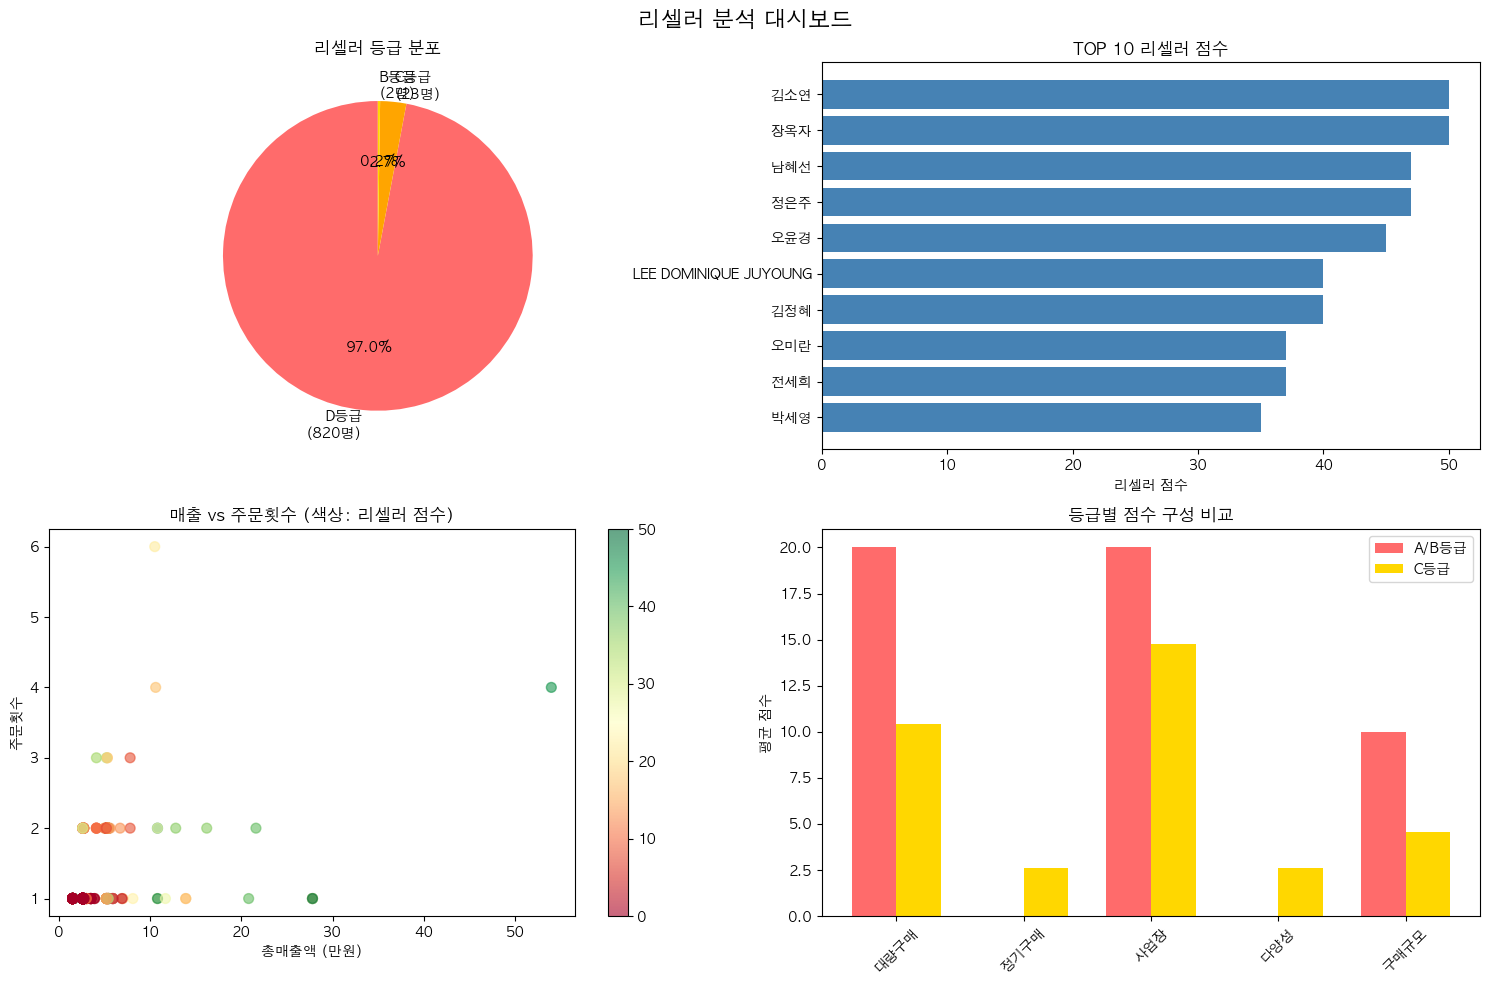

📊 대시보드 시각화 완료!


In [42]:
# 📊 시각화 대시보드 - 리셀러 분석
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('리셀러 분석 대시보드', fontsize=16, fontweight='bold')

# 1. 등급별 분포 (파이 차트)
ax1 = axes[0, 0]
grade_counts = final_results['등급'].value_counts()
colors = ['#FF6B6B', '#FFA500', '#FFD700', '#90EE90']
ax1.pie(grade_counts.values, labels=[f'{k}등급\n({v}명)' for k, v in grade_counts.items()], 
        colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('리셀러 등급 분포')

# 2. 상위 10명 점수 (막대 그래프)
ax2 = axes[0, 1]
top10 = final_results.nlargest(10, '리셀러점수')
ax2.barh(range(len(top10)), top10['리셀러점수'], color='steelblue')
ax2.set_yticks(range(len(top10)))
ax2.set_yticklabels(top10.index)
ax2.set_xlabel('리셀러 점수')
ax2.set_title('TOP 10 리셀러 점수')
ax2.invert_yaxis()

# 3. 매출 vs 주문횟수 (산점도)
ax3 = axes[1, 0]
scatter = ax3.scatter(final_results['총매출액']/10000, final_results['주문횟수'], 
                     c=final_results['리셀러점수'], cmap='RdYlGn', 
                     alpha=0.6, s=50)
ax3.set_xlabel('총매출액 (만원)')
ax3.set_ylabel('주문횟수')
ax3.set_title('매출 vs 주문횟수 (색상: 리셀러 점수)')
plt.colorbar(scatter, ax=ax3)

# 4. 점수 구성 요소 평균 (레이더 차트 대신 막대)
ax4 = axes[1, 1]
score_components = ['대량구매', '정기구매', '사업장', '다양성', '구매규모']
b_grade_avg = final_results[final_results['등급'].isin(['A', 'B'])][score_components].mean()
c_grade_avg = final_results[final_results['등급'] == 'C'][score_components].mean()

x = range(len(score_components))
width = 0.35
ax4.bar([i - width/2 for i in x], b_grade_avg, width, label='A/B등급', color='#FF6B6B')
ax4.bar([i + width/2 for i in x], c_grade_avg, width, label='C등급', color='#FFD700')
ax4.set_xticks(x)
ax4.set_xticklabels(score_components, rotation=45)
ax4.set_ylabel('평균 점수')
ax4.set_title('등급별 점수 구성 비교')
ax4.legend()

plt.tight_layout()
plt.show()

print("📊 대시보드 시각화 완료!")

## 🎯 잠재 리셀러 찾기 분석

리셀러의 특징:
- **대량 구매**: 일반 고객보다 많은 수량
- **정기적 구매**: 꾸준한 재주문 패턴
- **다양한 제품**: 여러 상품을 함께 구매
- **높은 매출**: 총 구매금액이 상위권

In [ ]:
# 데이터 간단 체크
print("\n🔍 통합 데이터 확인:")
print(df[['주문자명', '상품명', '주문수량', '총매출액']].head())
print(f"\n📊 총 데이터: {len(df):,}건")
print(f"👥 고객 수: {df['주문자명'].nunique():,}명")
print(f"📦 제품 종류: {df['상품명'].nunique()}개")
print(f"💰 총 매출: {df['총매출액'].sum():,}원")